In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, Text

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
#column headings stations 
# station,name,latitude,longitude,elevation
#column headings measurements
# station,date,prcp,tobs

In [6]:
# reflect an existing database into a new model
# reflect the tables

Base = automap_base()
Base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

SELECT MAX(date) 
FROM Measurement



In [10]:
# Find the most recent date in the data set.

most_recent_date_str = session.query(func.max(Measurement.date))\
    .scalar()
most_recent_date_str

'2017-08-23'

<class 'datetime.date'>


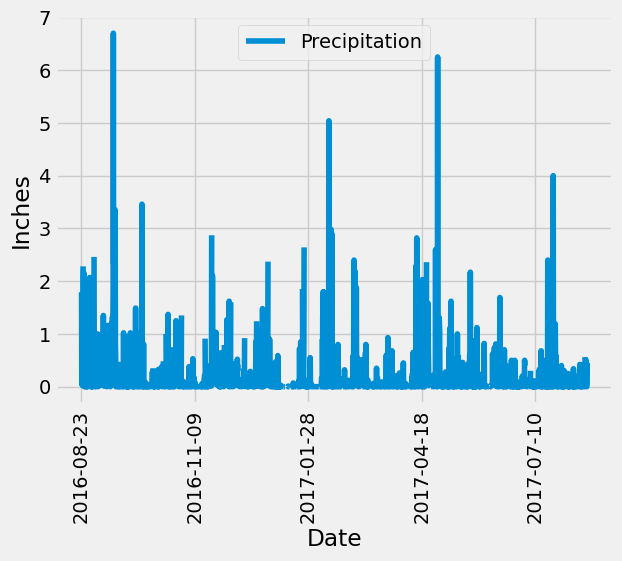

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Starting from the most recent data point in the database. 
most_recent_date = dt.date.fromisoformat(most_recent_date_str)
# Calculate the date one year from the last date in data set.

beginning_of_period = most_recent_date - dt.timedelta(days=365) 
print(type(beginning_of_period))

# Perform a query to retrieve the data and precipitation scores

date_precip_one_year = session.query(Measurement.date, Measurement.prcp)\
    .filter(Measurement.date >= beginning_of_period)\
    .all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names

date_precip_df = pd.DataFrame(date_precip_one_year)
date_precip_df

date_precip_df.rename(columns={0:"Date",1:"Precipitation"},inplace=True)
date_precip_df

# Sort the dataframe by date

date_precip_df.sort_values(by='Date', ascending =True, inplace=True)
date_precip_df


# Use Pandas Plotting with Matplotlib to plot the data
# Pandas plotting
date_precip_df.plot(x="Date",y="Precipitation",xlabel="Date", ylabel="Inches")
plt.xticks(rotation=90)
#Matplotlib
plt.show()


In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
date_precip_df.describe()




,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset

total_stations = session.query(Station.station).count()
total_stations


9

In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

#SQL Statement for conversion 
# SELECT station, COUNT(station)
# FROM Measurement
# GROUP BY station
# ORDER BY COUNT(station) desc


desc_stations_list = session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station).order_by(func.count(Measurement.station).desc())
              
for station in desc_stations_list:
    print(station)

    




('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.sum(Measurement.tobs)/func.count(Measurement.tobs)).\
                where(Measurement.station =='USC00519281').all()


[(54.0, 85.0, 71.66378066378067)]

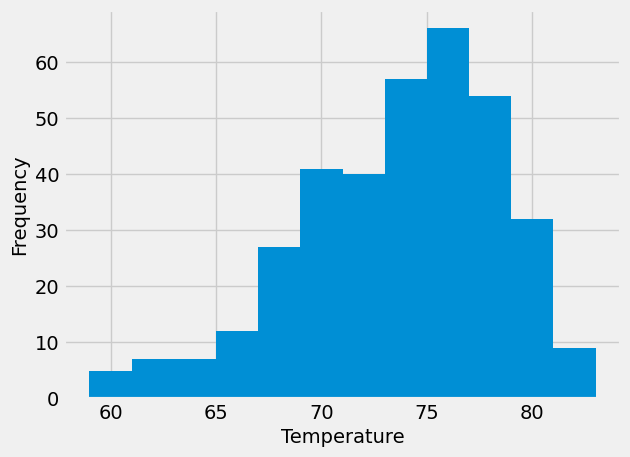

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sql_statement = """
SELECT date, tobs
FROM measurement
WHERE station is "USC00519281";
"""

df_temp = pd.read_sql(sql_statement, engine)

# Sort the dataframe by date
df_temp.sort_values(by="date", ascending=False, inplace=True)

values_int = []
# extract year month and day from the most recent date value
for i in df_temp['date'].iloc[0].split('-'):
    values_int.append(int(i))
yr, month, day = values_int

query_date = dt.date(yr, month, day) - dt.timedelta(days=365)
data = session.query(Measurement.date, Measurement.tobs).\
                where(Measurement.station=='USC00519281').\
                filter(Measurement.date >= query_date).all()
df_12month_temp = pd.DataFrame(data, columns=['date', 'tobs'])
df_12month_temp['tobs'].plot.hist(bins=12)
plt.xlabel('Temperature', size=14)
plt.ylabel('Frequency', size=14);

# Close Session

In [17]:
# Close Session
session.close()